In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

0.045373180522296566
170


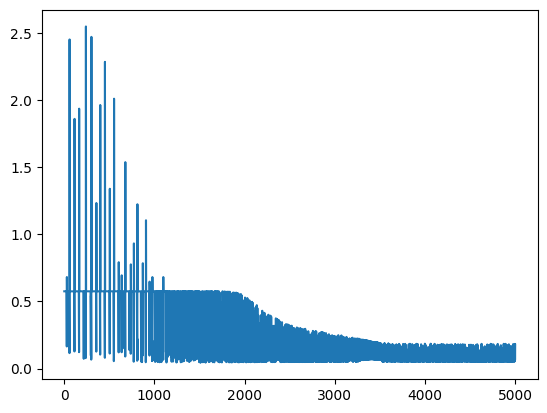

In [139]:

df = pd.read_csv("aps_failure_training_set.csv")
dataset = pd.DataFrame(df)
X = dataset.iloc[:, 2:170]
X = X.apply(pd.to_numeric, errors='coerce')

df_test = pd.read_csv("aps_failure_test_set.csv")
test_dataset = pd.DataFrame(df_test)
X_test = test_dataset.iloc[:, 1:169]
X_test = X_test.apply(pd.to_numeric, errors='coerce')


def get_min_max(dataset):
    minmax = []
    for col in dataset.columns:
        min_value = dataset[col].min()
        max_value = dataset[col].max()
        minmax.append([min_value, max_value])
    return minmax

def normalize_dataset(dataset, minmax):
    for i, col in enumerate(dataset.columns):
        if minmax[i][0] != minmax[i][1]:
            dataset[col] = (dataset[col] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

minmax = get_min_max(X)
normalize_dataset(X, minmax)
X.fillna(X.mean(), inplace=True)

minmax_test = get_min_max(X_test)
normalize_dataset(X_test, minmax_test)
X_test.fillna(X_test.mean(), inplace=True)

def PCA(dataset, components):
    mean = np.mean(dataset, axis=0)
    dataset = dataset - mean

    cov = np.cov(dataset.T)

    eigvalues, eigvectors = np.linalg.eig(cov)
    sorted_indices = np.argsort(eigvalues)[::-1]
    eigvalues = eigvalues[sorted_indices]
    eigvectors = eigvectors[sorted_indices]
    eigvectors = eigvectors.T
    #per = (np.sum(eigvalues[:6]) / np.sum(eigvalues)) * 100
    #print(per)

    eigvectors = eigvectors[:components]
    X_reduced = np.dot(dataset, eigvectors.T)

    return X_reduced
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None
    def fit(self, dataset, y):
        total_mean = np.mean(dataset, axis=0)
        classes = np.unique(y)
        n_columns = len(dataset.columns)
        SW_matrix = np.zeros((n_columns, n_columns))
        SB_matrix = np.zeros((n_columns, n_columns))
        for c in classes:
            dataset_C = dataset[y == c]
            mean_c = np.mean(dataset_C, axis=0)
            SW_matrix += np.dot((dataset_C - mean_c).T, (dataset_C - mean_c))
            n_c = dataset_C.shape[0]
            mean_diff = (mean_c - total_mean).values.reshape(n_columns, 1)
            SB_matrix += n_c * np.dot(mean_diff, mean_diff.T)

        S = np.linalg.inv(SW_matrix + 0.000001 * np.eye(n_columns)).dot(SB_matrix)
        eigvalues, eigvectors = np.linalg.eig(S)
        sorted_indices = np.argsort(abs(eigvalues))[::-1]
        eigvalues = eigvalues[sorted_indices].real
        eigvectors = eigvectors[sorted_indices].real
        eigvectors = eigvectors.T
        self.linear_discriminants = eigvectors[:self.n_components]
        #print(eigvalues[:5])
        #print(np.sum(abs(eigvalues[:1])) / np.sum(abs(eigvalues)) * 100)
    def transform(self, dataset):
        X_reduced = np.dot(dataset, self.linear_discriminants.T)
        return X_reduced


def cross_validation(X, y, k, num_folds):
    accuracies = []
    size = len(X) // num_folds
    predictions = []
    for i in range(num_folds):
        begin, end = i * size, (i + 1) * size
        train_set_x = np.concatenate([X[:begin], X[end:]])
        train_set_y = np.concatenate([y[:begin], y[end:]])
        values_x = X[begin:end]
        values_y = y[begin:end]

        y_pred = []
        accuracy = []
        
        for x in values_x:
            distances = np.sqrt(np.sum((train_set_x - x) ** 2, axis=1))
            indices = np.argsort(distances)
            k_nearest_indices = indices[:k]
            valid_indices = k_nearest_indices < len(train_set_y)
            k_nearest = train_set_y[valid_indices]
            uniques, counts = np.unique(k_nearest, return_counts=True)
            predicted = uniques[np.argmax(counts)]
            y_pred.append(predicted)
            predictions.append(predicted)
        
        accuracy = np.mean(values_y == y_pred)
        accuracies.append(accuracy)
        


    avg_accuracy = sum(accuracies) / len(accuracies)
    return avg_accuracy, predictions

def sigmoid(z):
    sigmoid = 1 / (1 + np.exp(-z))
    return sigmoid


def logistic_reg(X, y, alpha, iter):
    weights = np.zeros((np.shape(X)[1] + 1, 1))
    X = np.c_[np.ones((np.shape(X)[0], 1)), X] 
    
    def cost(theta):
        z = np.dot(X, theta)
        cost0 = y.T.dot(np.log(sigmoid(z) + 1e-15))
        cost1 = (1-y).T.dot(np.log(1-sigmoid(z) + 1e-15))
        cost = -((cost1 + cost0))/len(y)
        return cost.item()
    cost_list = np.zeros(iter)
    
    for i in range(iter):
        weights = weights - alpha* np.dot(X.T, sigmoid(np.dot(X,weights))- np.reshape(y, (len(y), 1)))
        cost_list[i] = cost(weights)
    return cost_list, weights


labels = dataset.iloc[:, 1]
X1 = X.iloc[:, :]
lda = LDA(1)
lda.fit(X1, labels)
X1_reduced = lda.transform(X1)
X1 = pd.DataFrame(X1_reduced)

"""
positive_indices = np.where(np.array(labels) == 'pos')[0]
positive_X1 = X1.iloc[positive_indices]
sorted_positives = positive_X1.sort_values(by=positive_X1.columns[0])
n_smallest = 600
selected_smallests = sorted_positives.head(n_smallest).index
oversampled_indices = np.random.choice(selected_smallests, size=len(X1), replace=True)
X1 = pd.concat([X1.iloc[oversampled_indices], X1], ignore_index=True)
labels = pd.concat([labels.iloc[oversampled_indices], labels], ignore_index=True)"""


X_test_reduced = lda.transform(X_test)
X_test = pd.DataFrame(X_test_reduced)
X_test = np.c_[np.ones((np.shape(X_test)[0], 1)), X_test]

mapping = {'pos': 1, 'neg': 0}
labels = labels.map(mapping)

costs, weights = logistic_reg(X1, labels, 0.01, 5000)
#print(min(costs))
#plt.plot(costs)

class_list = []

prob = sigmoid(np.dot(X_test, weights))

for j in prob:
    if j > 0.5:
        class_list.append(1)
    else:
        class_list.append(0)


print(class_list.count(1))

d_frame = pd.DataFrame({'id': range(1, len(class_list) + 1), 'class': ['neg' if c == 0 else 'pos' for c in class_list]})
file = 'predictions.csv'
d_frame.to_csv(file, index=False)



